In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from tqdm import tqdm_notebook
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
#from kmodes.kprototypes import KPrototypes
#from GowerDist import gower_distances
import scikitplot as skplt
import mglearn
import warnings
warnings.filterwarnings("ignore")

First, we download the data:

In [208]:
df = pd.read_csv('churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [209]:
df.shape

(7043, 21)

In [210]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Now let's take a look what are the possible values for each feature:

In [211]:
out = str()
for i in df.columns:
    print("{}:{}\n".format(i, df[i].unique()))

customerID:['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

gender:['Female' 'Male']

SeniorCitizen:[0 1]

Partner:['Yes' 'No']

Dependents:['No' 'Yes']

tenure:[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]

PhoneService:['No' 'Yes']

MultipleLines:['No phone service' 'No' 'Yes']

InternetService:['DSL' 'Fiber optic' 'No']

OnlineSecurity:['No' 'Yes' 'No internet service']

OnlineBackup:['Yes' 'No' 'No internet service']

DeviceProtection:['No' 'Yes' 'No internet service']

TechSupport:['No' 'Yes' 'No internet service']

StreamingTV:['No' 'Yes' 'No internet service']

StreamingMovies:['No' 'Yes' 'No internet service']

Contract:['Month-to-month' 'One year' 'Two year']

PaperlessBilling:['Yes' 'No']

PaymentMethod:['Electronic check' 'Mailed check' 'Bank transfer (automatic)'

# Exploratory data analysis

We have 3 quantitative variables (tenure, monthly charges and total charges), 1 ID variable and 17 categorical variables.

First, let's check if Customer IDs might convey any information:

In [212]:
assert len(df) == len(df['customerID'].unique())

IDs are unique for each observation and we can set them as index

In [213]:
df.set_index(['customerID'], inplace=True)

Now we move on to quantitative variables. **df['TotalCharges']** has string values although TotalCharges is clearly a numeric variable. This may be due to the presence of missing values that are not encoded as numbers. Let's get rid of this problem

In [214]:
# convert strings with numbers into floats, other values into NaNs
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce') 
df = df.dropna()
df.shape #let's see how many observations we are left with after dropping NaNs

(7032, 20)

Next we explore quantitative variables and check the presence of outliers or missing values encoded as numbers (e.g. -99). Firstly, we analyze given data by plotting histograms:

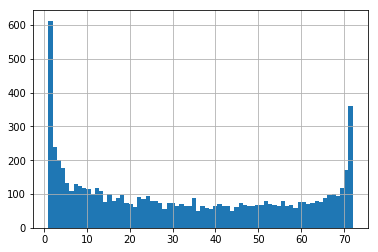

In [215]:
df.tenure.hist(bins = 72)

In [216]:
df.tenure.describe()

count    7032.000000
mean       32.421786
std        24.545260
min         1.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [217]:
len(df[df.tenure == 1])

613

In [218]:
len(df[df.tenure == 72])

362

As you can see, tenure varies between 1 and 72, having modes at the borders of the interval. The mode at 1 month is predictable since a lot of customers will churn soon after their first involvement. However, the mode at 72 months (3 years) might take place only because of the data collection process. Since we know that the company exists for more than 3 years, some of the observations with tenure equal to 72 might actually refer to the clients who have been with the company for more than 3 years. If these observations consist mostly of remaining customers, it would be better to drop these observations so as not to overestimate the impact of tenure.

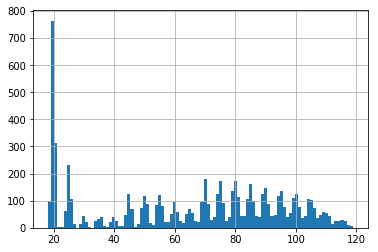

In [219]:
df.MonthlyCharges.hist(bins = 100)

In [220]:
df.MonthlyCharges.describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

This time we clearly have no outliers and also a mode in the area of 20

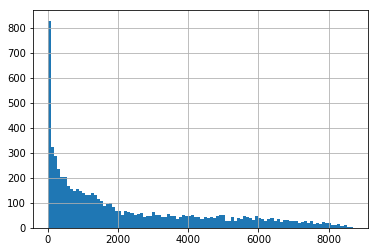

In [221]:
df.TotalCharges.hist(bins = 100)

In [222]:
df.TotalCharges.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: TotalCharges, dtype: float64

What we see here is that data is significantly skewed. Peak on the left looks very thin so that it looks like the mode includes only one value which occurs more than 800 times. However, this is not the case. Actual modal value occurs only a few times, which indicates that our distribution here has exponential form

In [223]:
len(df[df.TotalCharges == df.TotalCharges.mode()[0]])

11

Such a distribution of the variable suggests that we should consider applying the logarithmic transformation here.This way we will be able to capture the effect of relative rather than absolute increase in the variable which is more reasonable when the density of values decreases rapidly with respect to their size.

In [224]:
df['log_TotalCharges'] = np.log(df.TotalCharges)

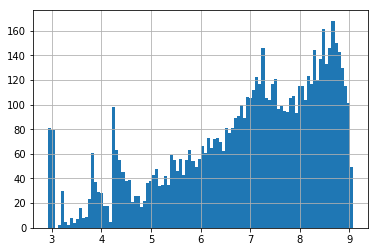

In [225]:
df.log_TotalCharges.hist(bins = 100)

Right now we have only one dummy variable: SeniorCitizen. Let's transform other categorical variables into dummies.

In [226]:
df = pd.get_dummies(df, drop_first = True) #leave one category out so as to avoid the dummy trap
df.rename(columns={s: s[:-4] for s in df.columns if 'Yes' in s}, inplace = True)
df.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,log_TotalCharges,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,...,StreamingTV,StreamingMovies_No internet service,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,29.85,3.396185,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
5575-GNVDE,0,34,56.95,1889.50,7.544068,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3668-QPYBK,0,2,53.85,108.15,4.683519,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
7795-CFOCW,0,45,42.30,1840.75,7.517928,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
9237-HQITU,0,2,70.70,151.65,5.021575,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


It might seem like we've avoided the perfect collinearity problem having left one category out for each categorical variable. However, we still have 7 identical features that provide information on the same factor - lack of internet service

In [227]:
df[[s for s in df.columns if 'No' in s and 'nternet' in s]].head()

,InternetService_No,OnlineSecurity_No internet service,OnlineBackup_No internet service,DeviceProtection_No internet service,TechSupport_No internet service,StreamingTV_No internet service,StreamingMovies_No internet service
customerID,,,,,,,
7590-VHVEG,0,0,0,0,0,0,0
5575-GNVDE,0,0,0,0,0,0,0
3668-QPYBK,0,0,0,0,0,0,0
7795-CFOCW,0,0,0,0,0,0,0
9237-HQITU,0,0,0,0,0,0,0


In [228]:
df.drop([s for s in df.columns if '_No internet service' in s], axis = 1, inplace = True)

In [229]:
df.shape

(7032, 26)

Let's look at how our variables are distributed conditional on the target class:

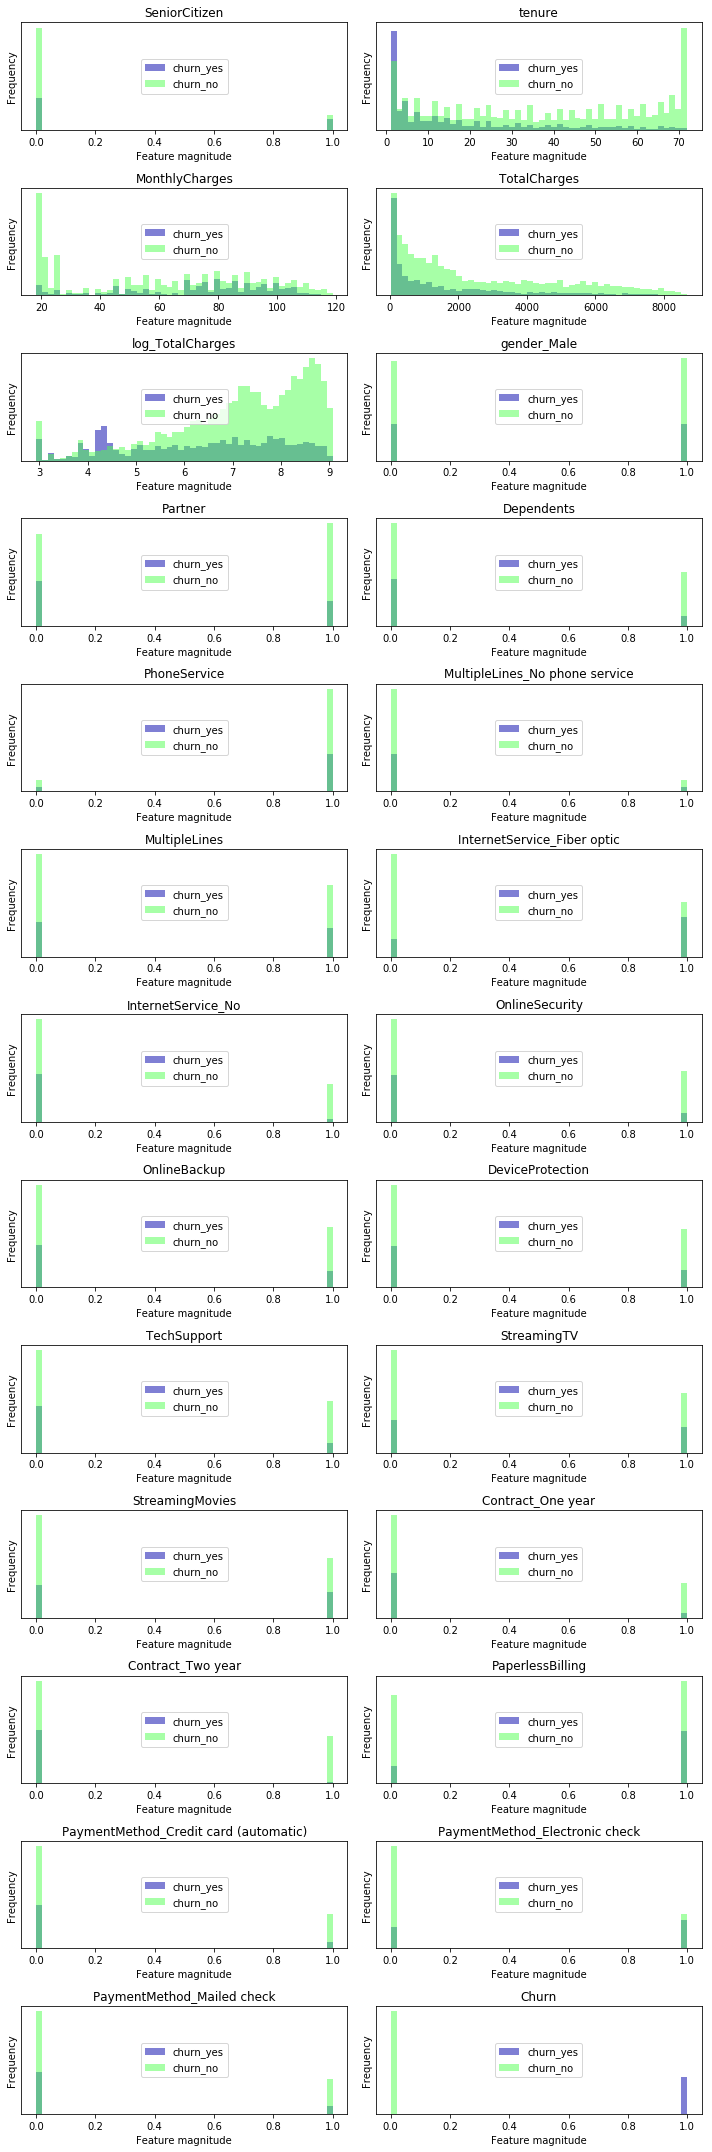

In [230]:
fig, axes = plt.subplots(13, 2, figsize=(10, 30))
churn_yes = df[df['Churn'] == 1]
churn_no = df[df['Churn'] == 0]

ax = axes.ravel()
for i in range(26):
    if i > 0 & i < 4:
        _, bins = np.histogram(df.values[:, i], bins=50)
    else:
        _, bins = np.histogram(df.values[:, i], bins=50)
    ax[i].hist(churn_yes.values[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(churn_no.values[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(df.columns[i])
    ax[i].set_yticks(())
    ax[i].set_xlabel("Feature magnitude")
    ax[i].set_ylabel("Frequency")
    ax[i].legend(["churn_yes", "churn_no"], loc="center")
    fig.tight_layout()

From these graphs we can see that all of our numeric variables are quite informative. As expected, distribution of tenure is skewed to the minimum for customers who churned and to the maximum for customers who did not. Mode in the right border, as was suspected earlier, indeed almost does not contain churning customers and should probably be dropped. Mode for monthly charges nearly completely consists of remaining customers, while those who churned tend to have higher monthly charges. What this means is that customers who stay do not tend to constantly spend a lot on services. From the total charges histograms we can see that churning customers constitute a minority for almost all of the range.

Not all the categorical values actually appear useful (e. g. gender). Among the factors that are clearly correlated with churning we can find being a senior citizen, using internet service and making month-to-month contracts

# Building an optimal model

Firstly, let's drop observations with the maximum value of tenure (i.e. observations that might actually have tenure higher than 3 years)

In [231]:
df = df[df.tenure != df.tenure.max()]

It is important to mention that our variables have different scales. Regularization methods work properly when variables have the same scale and, therefore, if we want to apply Lasso or Ridge regression, we should rescale our quantitative variables.

In [232]:
for x in ['tenure','MonthlyCharges','TotalCharges','log_TotalCharges']:
    df[x] = MinMaxScaler().fit_transform(df[x].values.reshape(-1,1))
    df.rename(columns = {x : x+'_scaled'}, inplace = True)

In [233]:
# now our quantitative variables are scaled in the range (0,1)
df.head()

,SeniorCitizen,tenure_scaled,MonthlyCharges_scaled,TotalCharges_scaled,log_TotalCharges_scaled,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,...,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,0.000000,0.115538,0.001293,0.075525,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
5575-GNVDE,0,0.471429,0.385458,0.218899,0.753111,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
3668-QPYBK,0,0.014286,0.354582,0.010455,0.285820,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
7795-CFOCW,0,0.628571,0.239542,0.213195,0.748841,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
9237-HQITU,0,0.014286,0.522410,0.015545,0.341044,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


We still do not know which specification is better: with logarithmic or original total charges, so let's start with testing linear specification,

To test the quality of our data we need to split data into train and test so as to avoid overfitting and 
improve generalization of our model

In [234]:
seed = 31

In [235]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['log_TotalCharges_scaled'], axis = 1).iloc[:,:-1], df.iloc[:,-1],random_state = seed )

In [236]:
model = LogisticRegression()

Now let's train our model on train set using cross-validation while choosing hyperparameters

Grid-Search with AUC
Best parameters: {'C': 10, 'penalty': 'l1'}
Best cross-validation score (AUC): 0.830
Test set AUC: 0.848


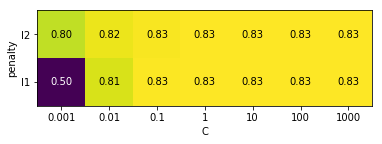

In [237]:
param_grid = {'penalty': ['l1', 'l2'], 
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=10, random_state = seed)
grid_search = GridSearchCV(model, param_grid=param_grid, cv = cv, scoring='roc_auc')
grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2).T
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
print("Grid-Search with AUC")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid_search.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid_search.decision_function(X_test))))

Now let's try the logarithmic total charges

In [238]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['TotalCharges_scaled'], axis = 1).iloc[:,:-1], df.iloc[:,-1], random_state = seed)

Grid-Search with AUC
Best parameters: {'C': 1, 'penalty': 'l2'}
Best cross-validation score (AUC): 0.835
Test set AUC: 0.854


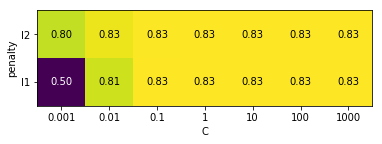

In [239]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv = cv, scoring='roc_auc')
grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2).T
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
print("Grid-Search with AUC")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid_search.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_test, grid_search.decision_function(X_test))))

We see that the best quality can be obtained with l2 penalty and C = 1 and logarithmic transformation of total charges.

Now let's plot lift and gain curves for the chosen model

In [240]:
df = df.drop(['TotalCharges_scaled'], axis = 1)

# Lift and gain charts of the optimized model

In [241]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], random_state = seed)

Let's look at the Lift Curve. As we can see, lift drops steeply from around 5 - to around 12 % of the sample, and then declines at approximately the same rate

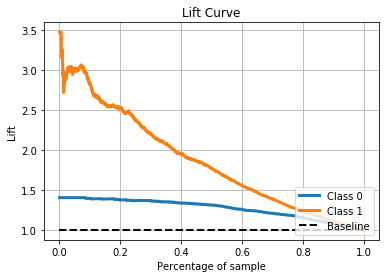

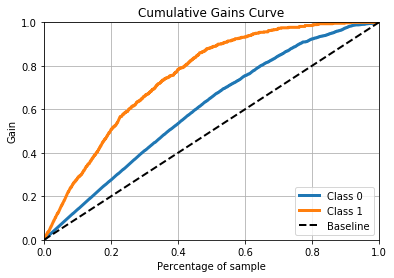

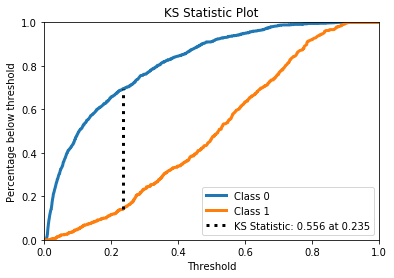

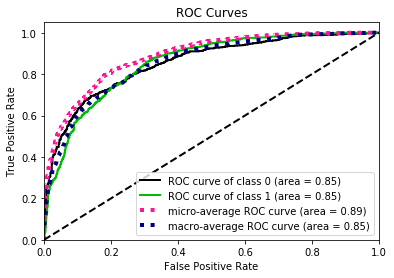

In [242]:
model = LogisticRegression(C = grid_search.best_params_['C'], penalty = grid_search.best_params_['penalty'])
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test.values, pred)
skplt.metrics.plot_cumulative_gain(y_test.values, pred)
skplt.metrics.plot_ks_statistic(y_test.values, pred)
skplt.metrics.plot_roc_curve(y_test.values, pred)

As we can see, lift curve becomes stable at around 5%, after that lift curve declines with the same rate.

# Using bootstrap for building CI of predictions

We create a function which calculates CI for predictions and coefficients of the model and also computes
some statistics of our metrics using bootstrap

In [243]:
np.random.seed(seed)

In [244]:
def bootstrap(df, n):
    all_preds = []
    all_coefs = []
    auc_score = []
    for i in range(n):
        indices = np.random.choice(range(len(X_train)), size = len(X_train), replace=True)
        X_tr, y_tr = X_train.iloc[list(indices)], y_train[list(indices)]
        model = LogisticRegression(C=1, penalty = 'l1')
        model.fit(X_train, y_train)
        pred = model.predict_proba(X_test)
        coefs = model.coef_
        all_coefs.append(model.coef_[0])
        all_preds.append(pred[:,1])
        auc_score.append(roc_auc_score(y_test, pred[:,1]))
    return np.array(auc_score), np.array(all_preds), np.array(all_coefs)

In [245]:
scores, all_preds, all_coefs = bootstrap(X_train, 1000)

Let's take a look at the statistics of the training score (AUC):

In [246]:
pd.Series(scores).describe()

count    1000.000000
mean        0.854465
std         0.000008
min         0.854416
25%         0.854463
50%         0.854467
75%         0.854468
max         0.854493
dtype: float64

Then we'll calculate 95% confidence intervals for our predictions and coefficients of the model using bootsrap:

In [247]:
CIs = pd.DataFrame({'prediction': np.array(all_preds).mean(axis = 0), 'upper bound (97.5%)': np.percentile(all_preds, 97.5, axis = 0), 'lower bound (2.5%)': np.percentile(all_preds, 2.5, axis = 0) })
CIs.head()

,prediction,upper bound (97.5%),lower bound (2.5%)
0,0.427779,0.427814,0.427745
1,0.036694,0.036719,0.036686
2,0.660459,0.660550,0.660416
3,0.761649,0.761676,0.761607
4,0.016554,0.016566,0.016550


Now let's calculate 95% confidence intervals for coefficients:

In [248]:
CIs = pd.DataFrame({'feature':X_train.columns, 'coefficient': np.array(all_coefs).mean(axis = 0), 'upper bound(97.5%)': np.percentile(all_coefs, 97.5, axis = 0), 'lower bound(2.5%)': np.percentile(all_coefs, 2.5, axis = 0) })
CIs.head()

,feature,coefficient,upper bound(97.5%),lower bound(2.5%)
0,SeniorCitizen,0.236325,0.236413,0.236265
1,tenure_scaled,-0.268389,-0.267644,-0.269878
2,MonthlyCharges_scaled,0.000000,0.000000,0.000000
3,log_TotalCharges_scaled,-3.372636,-3.369402,-3.373790
4,gender_Male,-0.021853,-0.021593,-0.021931


# Cut-off selection

Now let's find break even point for the targeting campaign.

In [249]:
model = LogisticRegression(C = grid_search.best_params_['C'], penalty = grid_search.best_params_['penalty'])
model.fit(df.iloc[:,:-1], df.iloc[:,-1])

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [250]:
def break_even(df, model, plot_start = 0, plot_end = None):
    pred = model.predict_proba(df.iloc[:,:-1])          # predicting the probability of churning
    series = pd.Series(pred[:,1], index = df.index)     # building a series with customer ID as index
    series.sort_values(ascending = False, inplace = True)
    prob = series.values                # probability of churning for each customer in descending order
    revenues = 25 * 0.25 * prob         # expected revenues from retention campaign for each customer
    cum_revenues = np.array([sum(revenues[:i + 1]) for i in range(len(revenues))])    # cumulative expected revenues
    cost = np.array([5 * (i + 1) for i in range(len(revenues))])                      # cumulative cost
    profit = cum_revenues - cost
    
    if plot_end == None:
        plot_end = len(revenues)
      
    plt.plot([i + 1 for i in range(plot_start, plot_end)], cost[plot_start:plot_end])
    plt.plot([i + 1 for i in range(plot_start, plot_end)], cum_revenues[plot_start:plot_end])
    plt.xlabel('Number of people targeted with the campaign')
    plt.ylabel('Euros')
    plt.legend(['Costs', 'Revenues'])
    plt.title('Break even')
    plt.show()
    
    plt.plot([i + 1 for i in range(plot_start, plot_end)], profit[plot_start:plot_end])
    plt.xlabel('Number of people targeted with the campaign')
    plt.ylabel('Total profit (Revenue - Costs)')
    plt.title('Profit')
    plt.show()
    
    max_profit_customers, max_customers = np.where(profit == max(profit))[0][0] + 1, np.where(profit < 0)[0][0]
    
    print('Maximum number of customer to be targeted without losing money: {} (Break even point)'.format(max_customers))
    print('Number of customer to be targeted for maximum profit: {}'.format(max_profit_customers))
    print('The function returns a list of customers to be contacted by the retention campaign')
    
    return series.index[:max_customers]

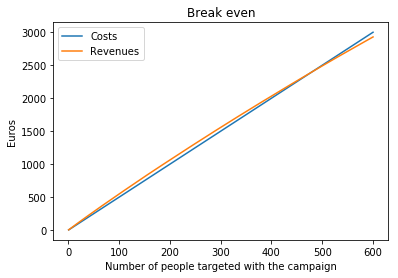

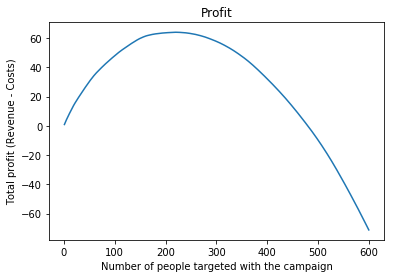

Maximum number of customer to be targeted without losing money: 479 (Break even point)
Number of customer to be targeted for maximum profit: 219
The function returns a list of customers to be contacted by the retention campaign


Index(['7216-EWTRS', '5178-LMXOP', '9497-QCMMS', '9300-AGZNL', '5419-JPRRN',
       '8149-RSOUN', '4910-GMJOT', '0295-PPHDO', '3068-OMWZA', '4826-XTSOH',
       ...
       '3462-BJQQA', '7242-QZLXF', '1251-STYSZ', '0495-ZBNGW', '9334-GWGOW',
       '2424-WVHPL', '9894-EZEWG', '6275-YDUVO', '3186-BAXNB', '6683-VLCTZ'],
      dtype='object', name='customerID', length=479)

In [251]:
break_even(df, model, 0, 600)

## PCA

Now we'll try to make linear combinations of our features (PC) and see whether it improves the quality of our model.

Obviously, it is not an option to transform categorical variables, so we test the quality of the model with PCA
only transforming quantitative features:

In [252]:
df.reset_index(inplace=True)
df.drop('customerID', axis = 1, inplace=True)
df.head()

,SeniorCitizen,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,...,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0.000000,0.115538,0.075525,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0.471429,0.385458,0.753111,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0.014286,0.354582,0.285820,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,0.628571,0.239542,0.748841,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0.014286,0.522410,0.341044,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


Firstly let's try to replace out numeric variables **only with first PC** (out of 3):

In [253]:
X_s = StandardScaler().fit_transform(df.iloc[:,:3])
pca = PCA(n_components = 1)
df_pca = pd.DataFrame(pca.fit_transform(X_s), columns = ['PC {0}'.format(i + 1) for i in range(1)])
print('1st PC explains', sum(pca.explained_variance_ratio_), 'of total variance of numeric variables')

1st PC explains 0.44299489430932093 of total variance of numeric variables


In [254]:
df_pca = pd.merge(df_pca, df, left_index=True, right_index=True)
df_pca.head()

,PC 1,SeniorCitizen,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,...,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.656681,0,0.000000,0.115538,0.075525,0,1,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,-0.307392,0,0.471429,0.385458,0.753111,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,-1.073101,0,0.014286,0.354582,0.285820,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,-0.412134,0,0.628571,0.239542,0.748841,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
4,-0.678587,0,0.014286,0.522410,0.341044,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


In [255]:
df_pca = df_pca.dropna()
df_pca = df_pca.drop(['tenure_scaled','MonthlyCharges_scaled','log_TotalCharges_scaled'], axis = 1)
X_pca = df_pca.iloc[:,:-1]
X_pca.head()

,PC 1,SeniorCitizen,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,InternetService_Fiber optic,InternetService_No,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.656681,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,-0.307392,0,1,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,-1.073101,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.412134,0,1,0,0,0,1,0,0,0,...,1,1,0,0,1,0,0,0,0,0
4,-0.678587,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


In [256]:
y_pca = df_pca['Churn']

In [257]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, random_state = seed)

In [258]:
model = LogisticRegression()

Grid-Search with AUC
Best parameters: {'C': 1000, 'penalty': 'l1'}
Best cross-validation score (AUC): 0.827
Test set AUC: 0.845


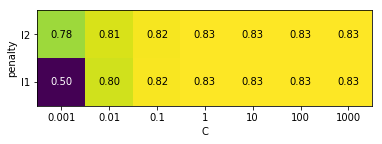

In [259]:
param_grid = {'penalty': ['l1', 'l2'], 
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=10, random_state = seed)
grid_search = GridSearchCV(model, param_grid=param_grid, cv = cv, scoring='roc_auc')
grid_search.fit(X_pca_train, y_pca_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2).T
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
print("Grid-Search with AUC")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid_search.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_pca_test, grid_search.decision_function(X_pca_test))))

In [260]:
model = LogisticRegression(C = grid_search.best_params_['C'], penalty = grid_search.best_params_['penalty'])
model.fit(X_pca_train, y_pca_train)
pred = model.predict_proba(X_pca_test)

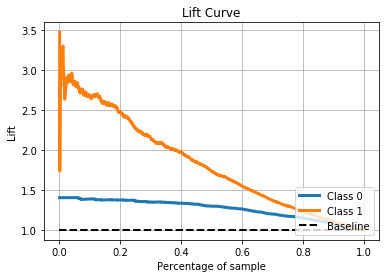

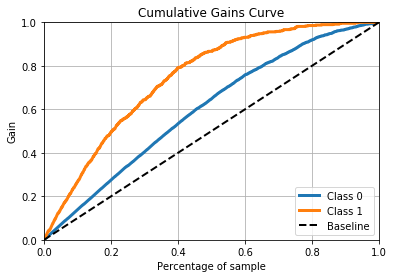

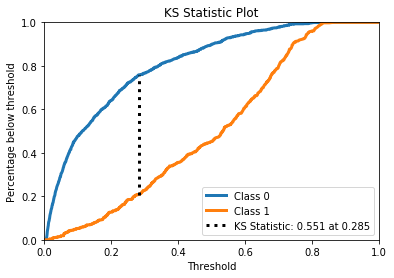

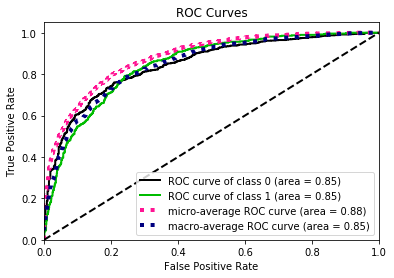

In [261]:
skplt.metrics.plot_lift_curve(y_pca_test, pred)
skplt.metrics.plot_cumulative_gain(y_pca_test, pred)
skplt.metrics.plot_ks_statistic(y_pca_test, pred)
skplt.metrics.plot_roc_curve(y_pca_test, pred)

We see that results got worse

Now let's try the same with **2 principal components**:

In [262]:
pca = PCA(n_components = 2)
df_pca = pd.DataFrame(pca.fit_transform(X_s), columns = ['PC {0}'.format(i + 1) for i in range(2)])
print('First two PCs explains', sum(pca.explained_variance_ratio_), 'of total variance of numeric variables')

First two PCs explains 0.7698678500118021 of total variance of numeric variables


In [263]:
df_pca = pd.merge(df_pca, df, left_index=True, right_index=True)
df_pca.head()

,PC 1,PC 2,SeniorCitizen,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled,gender_Male,Partner,Dependents,PhoneService,...,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,-1.656681,0.578390,0,0.000000,0.115538,0.075525,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0
1,-0.307392,-0.424021,0,0.471429,0.385458,0.753111,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,-1.073101,0.548364,0,0.014286,0.354582,0.285820,1,0,0,1,...,0,0,0,0,0,1,0,0,1,1
3,-0.412134,-0.758516,0,0.628571,0.239542,0.748841,1,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,-0.678587,0.548618,0,0.014286,0.522410,0.341044,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1


In [264]:
df_pca = df_pca.dropna()
df_pca = df_pca.drop(['tenure_scaled','MonthlyCharges_scaled','log_TotalCharges_scaled'], axis = 1)
X_pca = df_pca.iloc[:,:-1]
X_pca.head()

,PC 1,PC 2,SeniorCitizen,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,InternetService_Fiber optic,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,-1.656681,0.578390,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,-0.307392,-0.424021,0,1,0,0,1,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,-1.073101,0.548364,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
3,-0.412134,-0.758516,0,1,0,0,0,1,0,0,...,1,1,0,0,1,0,0,0,0,0
4,-0.678587,0.548618,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [265]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca, y_pca, random_state = seed)

In [266]:
model = LogisticRegression()

Grid-Search with AUC
Best parameters: {'C': 1, 'penalty': 'l1'}
Best cross-validation score (AUC): 0.827
Test set AUC: 0.845


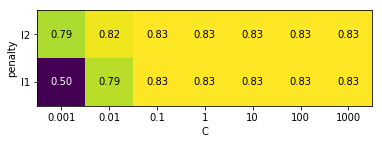

In [267]:
param_grid = {'penalty': ['l1', 'l2'], 
             'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
cv = ShuffleSplit(train_size=0.8, test_size=0.2, n_splits=10, random_state = seed)
grid_search = GridSearchCV(model, param_grid=param_grid, cv = cv, scoring='roc_auc')
grid_search.fit(X_pca_train, y_pca_train)
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(7, 2).T
mglearn.tools.heatmap(scores, xlabel='C', xticklabels=param_grid['C'],
                      ylabel='penalty', yticklabels=param_grid['penalty'], cmap="viridis")
print("Grid-Search with AUC")
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score (AUC): {:.3f}".format(grid_search.best_score_))
print("Test set AUC: {:.3f}".format(roc_auc_score(y_pca_test, grid_search.decision_function(X_pca_test))))

In [268]:
model = LogisticRegression(C = grid_search.best_params_['C'], penalty = grid_search.best_params_['penalty'])
model.fit(X_pca_train, y_pca_train)
pred = model.predict_proba(X_pca_test)

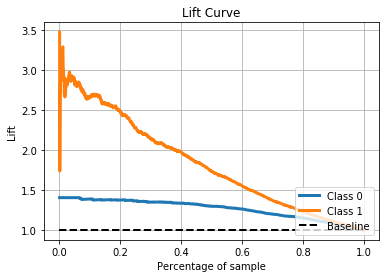

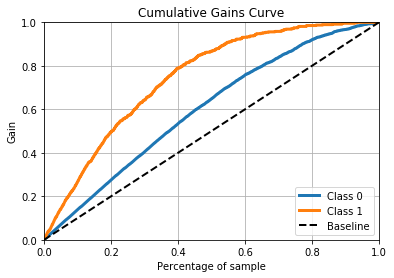

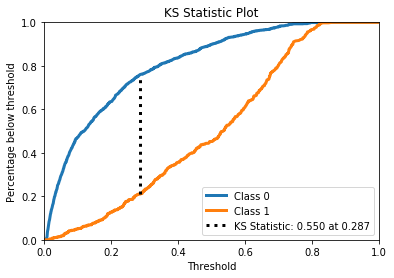

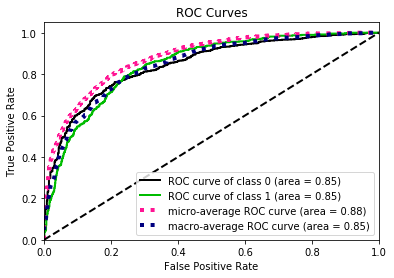

In [269]:
skplt.metrics.plot_lift_curve(y_pca_test, pred)
skplt.metrics.plot_cumulative_gain(y_pca_test, pred)
skplt.metrics.plot_ks_statistic(y_pca_test, pred)
skplt.metrics.plot_roc_curve(y_pca_test, pred)

And again we don't see any improvement in AUC score

# K-Prototypes (Appendix)

We need to stress that we can't use KNN algorithm for clustering due to most of our features are categorical

Though we can try to infer any insights from cluster analysis. In order to split clients to some groups we'll use K-prototypes technique, which enables us to account for dissimilarities of both numeric and categorical variables between observations

In [186]:
X = df

In [188]:
#functions that counts mean of Gower distances between observations in each cluster
def avGD(X, labels, N):
    GDs = []
    for i in range(N):
        GD = gower_distances(X[np.where(labels == 0)[0]], categorical_features= [True]*1+[False]*3+[True]*21)
        GDs.append(np.sum(GD)/(2*GD.shape[0]))
    return sum(GDs) 

Let's run a loop in which we calculate Gower's distance on each step to define the best size of the clusters for customer and product data.

In [189]:
X.head()

,SeniorCitizen,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,...,TechSupport,StreamingTV,StreamingMovies,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,0.000000,0.115538,0.075525,0,1,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0.471429,0.385458,0.753111,1,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0.014286,0.354582,0.285820,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,1
3,0,0.628571,0.239542,0.748841,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,0
4,0,0.014286,0.522410,0.341044,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,1


In [190]:
res_prod = []
for i in range(2,10):
    kp_prod = KPrototypes(n_clusters=i, init='Huang', n_init=5, verbose=0)
    clusters_kprod = kp_prod.fit_predict(X.values, categorical=[0]+list(range(4,25)))
    res_prod.append(avGD(X.values, clusters_kprod, i))

Text(0,0.5,'Mean Gower distance')

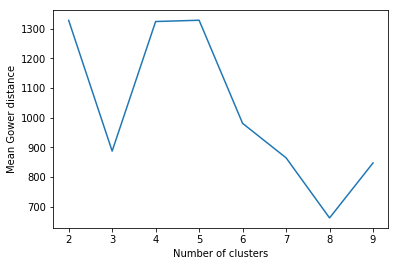

In [191]:
#let's take a look at how distence changes conditional of number of clusters
plt.plot(list(range(2,10)),res_prod)
plt.xlabel('Number of clusters')
plt.ylabel('Mean Gower distance')

therefore 8 clusters are the most suitable for us

In [192]:
kpp = KPrototypes(n_clusters=8, init='Huang', n_init=5, verbose=0)

In [200]:
clusters_kpp = kpp.fit_predict(X.values, categorical = [0]+list(range(4,25)))
counts_prods = pd.Series(clusters_kpp).value_counts()
X['clustersModes'] = clusters_kpp

In [201]:
X_nums = X.groupby(['clustersModes']).mean()[['tenure_scaled', 'MonthlyCharges_scaled', 'log_TotalCharges_scaled']]

In [202]:
import scipy.stats as stats

In [203]:
X_cats = X.groupby(['clustersModes']).agg(lambda x: stats.mode(x)[0][0]).iloc[:, [0]+list(range(4,25))]

In [204]:
X_nums.head()

,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled
clustersModes,,,
0,0.155479,0.094997,0.359395
1,0.653845,0.767010,0.878761
2,0.852499,0.655860,0.906700
3,0.094225,0.362988,0.358255
4,0.677935,0.059764,0.652983


In [205]:
total_X = pd.merge(X_cats, X_nums, right_index = True, left_index = True)

In [208]:
total_X.head()

,SeniorCitizen,gender_Male,Partner,Dependents,PhoneService,MultipleLines_No phone service,MultipleLines,InternetService_Fiber optic,InternetService_No,OnlineSecurity,...,Contract_One year,Contract_Two year,PaperlessBilling,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn,tenure_scaled,MonthlyCharges_scaled,log_TotalCharges_scaled
clustersModes,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0.155479,0.094997,0.359395
1,0,0,1,0,1,0,1,1,0,0,...,0,0,1,0,0,0,0,0.653845,0.767010,0.878761
2,0,0,1,0,1,0,1,0,0,1,...,0,1,1,0,0,0,0,0.852499,0.655860,0.906700
3,0,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,0.094225,0.362988,0.358255
4,0,1,1,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0.677935,0.059764,0.652983


Current dataframe just helps us get understanding of representative observations in our dataset: namely, what the modes
    of numeric variables and the most frequent values of categorical variables for each cluster are.    

# Conclusion

We used Logistic Regression.

Best specification of the model includes using log(total charges) instead of the original total charges variable.

Best quality can be obtained with parameters: L2 penalty and C equal to 1.

Break-even point, in a Target Retention Commercial Campaign occurs with 479th client.

Maximum-profit point would occur by contacting 219 clients (because of decreasing returns to scale in our campaign – 
after 113th client, expected revenue per user declines together with the probability of retaining that customer).

Clients that ought to be contacted in the campaign are carefully chosen and put in a table according to decreasing churn probability.


Note: PCA produced worse results; KNN clustering algorithm is not suitable for this specific case because most of our data features are categorical.
